In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

In [10]:
# Read unemployment data
unemp = pd.read_csv('DC2Data/unemployment.csv')
unemp = unemp.dropna()

pattern = r'^\d{4}\s[A-Z]{3}$'

# # Filter the DataFrame using the regular expression pattern
unemp = unemp[unemp['Title'].str.contains(pattern)]
unemp['Title'] = pd.to_datetime(unemp['Title'], format='%Y %b')
unemp.columns = ['ds', 'Unemployment']
# unemp = unemp.set_index('Date')
unemp["Unemployment"] = unemp["Unemployment"].astype(float)
unemp['change'] = unemp['Unemployment'].diff()
unemp = unemp.dropna()

In [11]:
# Read inflation data
inflation = pd.read_csv('DC2Data/inflation.csv')
inflation = inflation.dropna()

pattern = r'^\d{4}\s[A-Z]{3}$'

# # Filter the DataFrame using the regular expression pattern
inflation = inflation[inflation['Title'].str.contains(pattern)]

inflation.columns = ['ds', 'Inflation']
inflation['ds'] = pd.to_datetime(inflation['ds'], format='%Y %b')
# inflation = inflation.set_index('Date')
inflation["Inflation"] = inflation["Inflation"].astype(float)
inflation['change'] = inflation['Inflation'].diff()
inflation = inflation.dropna()
inflation

,ds,Inflation,change
179,1989-02-01,5.8,0.1
180,1989-03-01,5.9,0.1
181,1989-04-01,5.6,-0.3
182,1989-05-01,5.9,0.3
183,1989-06-01,5.8,-0.1
...,...,...,...
585,2022-12-01,9.2,-0.1
586,2023-01-01,8.8,-0.4
587,2023-02-01,9.2,0.4
588,2023-03-01,8.9,-0.3


In [12]:
# Read GDP data
gdp = pd.read_csv('DC2Data/GDPMonthly.csv')
gdp.columns = ['ds', 'GDP']
gdp.dropna(inplace=True)

# Function to check if a value is a valid date in the format 'MMM YYYY'
def is_valid_date(date_str):
    try:
        datetime.strptime(date_str, '%b %Y')
        return True
    except ValueError:
        return False

# Filter dataframe to include only rows with valid dates in the 'ds' column
gdp = gdp[gdp['ds'].apply(is_valid_date)]
gdp['ds'] = pd.to_datetime(gdp['ds'], format='%b %Y')
gdp['GDP'] = gdp['GDP'].astype(float)
gdp['change'] = gdp['GDP'].diff()
gdp = gdp.dropna()


In [13]:
merged = pd.merge(unemp, inflation, on='ds')
merged = pd.merge(merged, gdp, on='ds')
merged.columns = ['ds', 'Unemployment', 'UnemploymentChange', 'Inflation', 'InflationChange', 'GDP', 'GDPChange']
merged

,ds,Unemployment,UnemploymentChange,Inflation,InflationChange,GDP,GDPChange
0,2007-02-01,5.5,0.0,2.7,0.0,84.6,0.6
1,2007-03-01,5.5,0.0,2.9,0.2,84.9,0.3
2,2007-04-01,5.4,-0.1,2.7,-0.2,84.9,0.0
3,2007-05-01,5.4,0.0,2.5,-0.2,85.0,0.1
4,2007-06-01,5.3,-0.1,2.5,0.0,85.0,0.0
...,...,...,...,...,...,...,...
188,2022-10-01,3.7,0.0,9.6,0.8,100.4,0.7
189,2022-11-01,3.7,0.0,9.3,-0.3,100.5,0.1
190,2022-12-01,3.7,0.0,9.2,-0.1,100.0,-0.5
191,2023-01-01,3.8,0.1,8.8,-0.4,100.5,0.5


In [14]:
# read the crime data
crime = pd.read_csv('DC2Data/wards_crime_covid_adjusted_filled_rnd_gaps.csv')
crime["ds"] = pd.to_datetime(crime["ds"], format='%Y-%m-%d')
# limit the data to everything before 2020
# test_set = merged[merged['ds'] >= '2020-01-01']
# crime = crime[crime['ds'] < '2020-01-01']
crime = crime.set_index('ds')

In [8]:
scores_with =[]
scores_without = []

for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')

    train_set = merg[merg['ds'] < '2020-01-01']
    test_set = merg[merg['ds'] >= '2020-01-01']
    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = train_set[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = train_set['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    score_with = model.rsquared
    scores_with.append(score_with)
    # print(f"{group} with GDP: {score_with}")
    X = train_set[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange']]
    y = train_set['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    score_without = model.rsquared
    scores_without.append(score_without)
    # print("Ward " + str(group) + " with GDP: " + str(score_with) + " without GDP: " + str(score_without))
    # print("Difference: " + str(score_with - score_without))

    X = test_set[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = test_set['trend']
    X = sm.add_constant(X)
    predictions = model.predict(X)
    test_set['predictions'] = predictions
    test_set.plot(y=['y', 'predictions'], title=group)
    plt.show()

    # predictions = model.predict(X)
    # merg['predictions'] = predictions




# print("Average score with GDP: " + str(sum(scores_with)/len(scores_with)))
# print("Average score without GDP: " + str(sum(scores_without)/len(scores_without)))
# print("\n")
# print("Median score with GDP: " + str(sorted(scores_with)[len(scores_with)//2]))
# print("Median score without GDP: " + str(sorted(scores_without)[len(scores_without)//2]))
# print("\n")
# print("Max score with GDP: " + str(max(scores_with)))
# print("Max score without GDP: " + str(max(scores_without)))
# print("\n")
# print("Min score with GDP: " + str(min(scores_with)))
# print("Min score without GDP: " + str(min(scores_without)))

ValueError: shapes (38,7) and (5,) not aligned: 7 (dim 1) != 5 (dim 0)

In [ ]:
# Initialize lists to store scores
scores_with = []
scores_without = []

for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')
    merg.dropna(inplace=True)

    train_set = merg[merg['ds'] < '2020-01-01']
    train_set.set_index('ds')
    test_set = merg[merg['ds'] >= '2020-01-01']
    test_set.set_index('ds')

    # Linear regression on y
    X_train = train_set[['Unemployment', 'UnemploymentChange', 'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y_train = train_set['trend']
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    score_with = model.rsquared
    scores_with.append(score_with)


    X_test = test_set[['Unemployment', 'UnemploymentChange', 'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    X_test.dropna()
    X_test = sm.add_constant(X_test)
    predictions = model.predict(X_test)
    # print(X_test)
    # print(predictions)
    test_set['predictions'] = predictions
    # Plot the predictions
    test_set.plot(y=['y', 'predictions'], title=group)
    plt.show()
    break

In [ ]:
crime[crime["Ward"] == "West Hendon Ward"]

In [ ]:

for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')

    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = merg[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = merg['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    merg['predictions'] = predictions
    # plot the crime data and predictions
    fig, ax = plt.subplots()
    ax.plot(merg['trend'], color='blue', label='Crime')
    ax.plot(merg['predictions'], color='red', label='Predictions')
    ax.set_xlabel('Date')
    ax.set_ylabel('Crime')
    ax.legend(loc='upper left')
    plt.title('Ward ' + str(group))
    # plt.show()
    # fig.savefig('plots/Ward ' + str(group) + '.png')

In [ ]:
# plot the crime data and predictions on a 6x4 grid
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
count = 1
for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')

    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = merg[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = merg['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    merg['predictions'] = predictions
    # plot the crime data and predictions
    ax = axs[(count-1)//4, (count-1)%4]
    ax.plot(merg['trend'], color='blue', label='Crime')
    ax.plot(merg['predictions'], color='red', label='Predictions')
    ax.set_xlabel('Date')
    ax.set_ylabel('Crime')
    ax.legend(loc='upper left')
    ax.set_title(str(group))
    count += 1
plt.show()

In [ ]:
# plot all the residuals on one graph
fig, ax = plt.subplots()
for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')

    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = merg[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = merg['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    merg['predictions'] = predictions
    # plot the crime data and predictions
    merg['residuals'] = merg['trend'] - merg['predictions']
    ax.plot(merg['residuals'], label=group)
    ax.set_xlabel('Month')
    ax.set_ylabel('Residuals')
    #add horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='--')
    fig.savefig('plots/residuals.png')

In [82]:
from sklearn.metrics import r2_score
scores_basic=[]
# reintroducing the seasonality to the predictions
for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')
    merg.set_index('ds')
    merg.dropna(inplace=True)
    # Linear regression on y
    X = merg[['Unemployment','UnemploymentChange',  'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = merg['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    merg['predictions'] = predictions
    seasonality = decomp.seasonal
    merg = pd.merge(merg, seasonality, on='ds')
    merg['predictions'] = merg['predictions'] + merg['seasonal']
        # calculate r2 score between original and predictions
    r2 = r2_score(merg['y'], merg['predictions'])
    scores_basic.append(r2)

    # # plot the crime data and predictions
    # fig, ax = plt.subplots()
    # # ax.plot(merg['trend'], color='blue', label='Crime')
    # ax.plot(merg['y'], color='green', label='Original')
    # ax.plot(merg['predictions'], color='red', label='Predictions')
    #
    #
    # # print('R2 score for' + str(group) + ': ' + str(r2))
    #
    # ax.set_xlabel('Date')
    # ax.set_ylabel('Crime')
    # ax.legend(loc='upper left')
    # plt.title('Ward ' + str(group))
    # #scale the y axis to start at 0 and end at the max value of the original data
    # ax.set_ylim([0, merg['y'].max()])
    # plt.show()
    # fig.savefig('plots/with_seasonal/' + str(group) + '.png')
    # break


C:\Users\20210777\PycharmProjects\DataChallenge2\venvTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\20210777\PycharmProjects\DataChallenge2\venvTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\20210777\PycharmProjects\DataChallenge2\venvTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\20210777\PycharmProjects\DataChallenge2\venvTemp\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\20210777\PycharmProjects\DataChalle

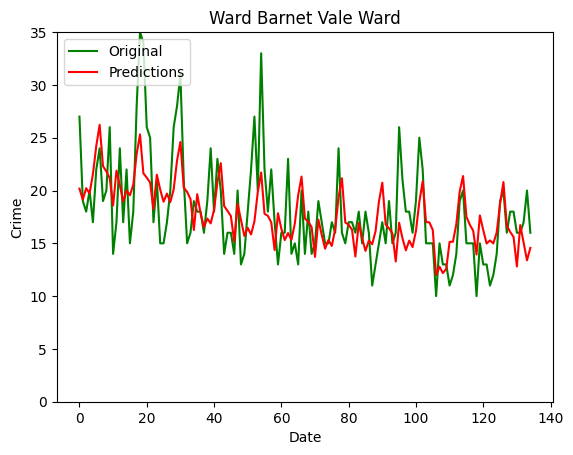

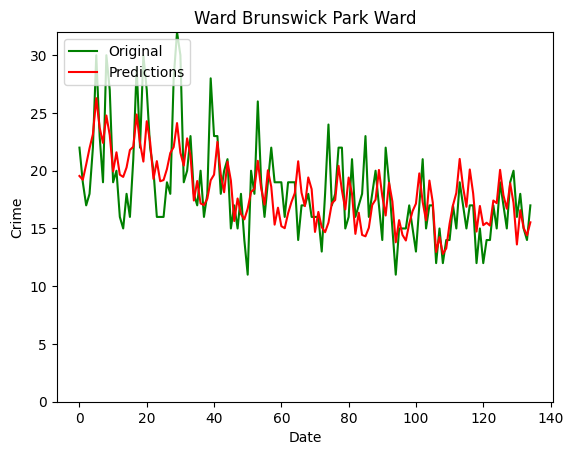

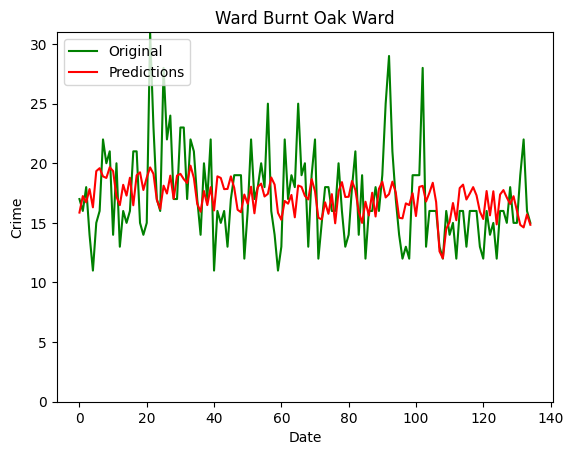

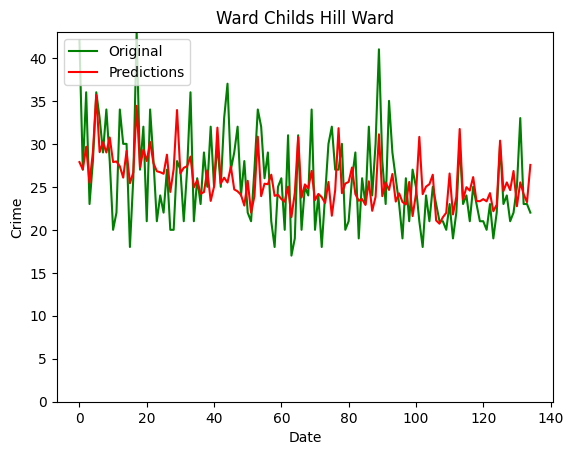

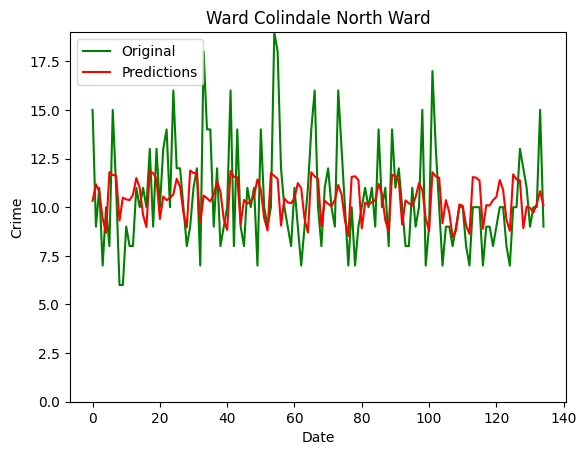

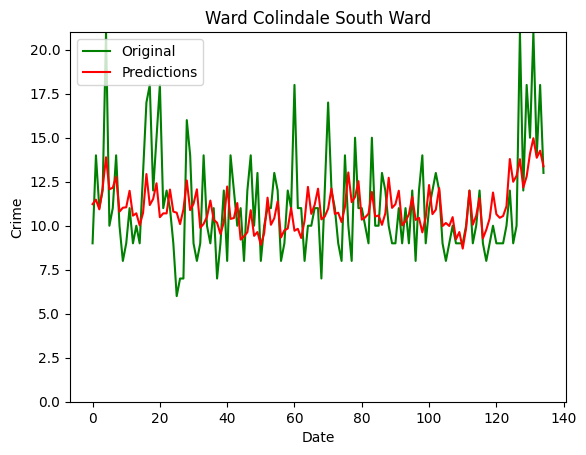

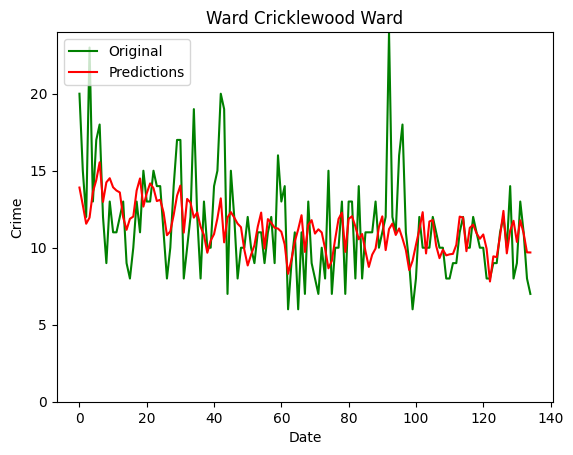

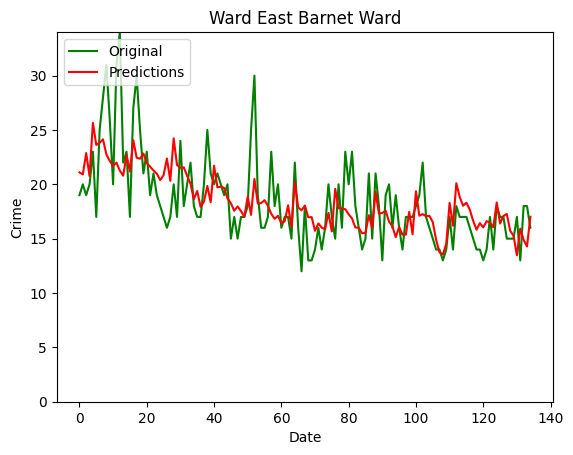

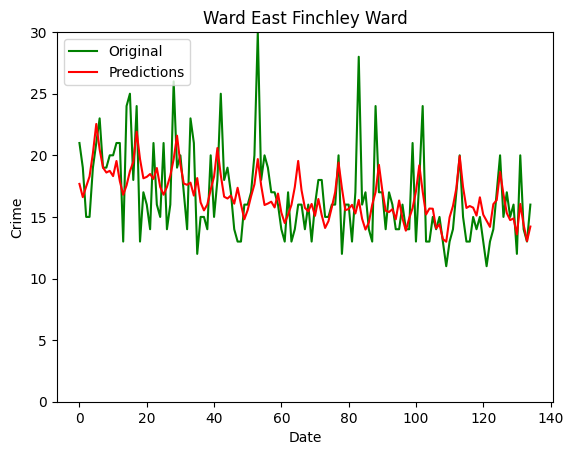

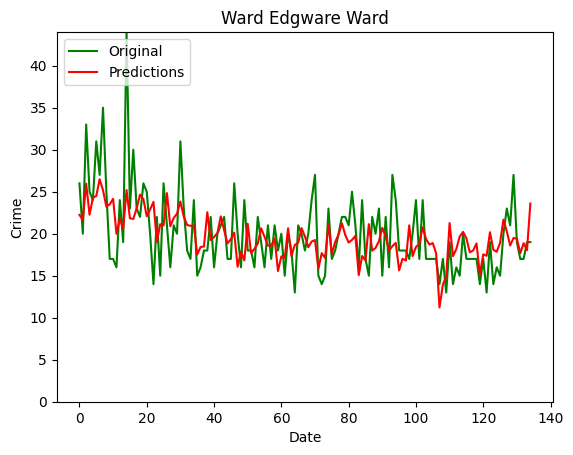

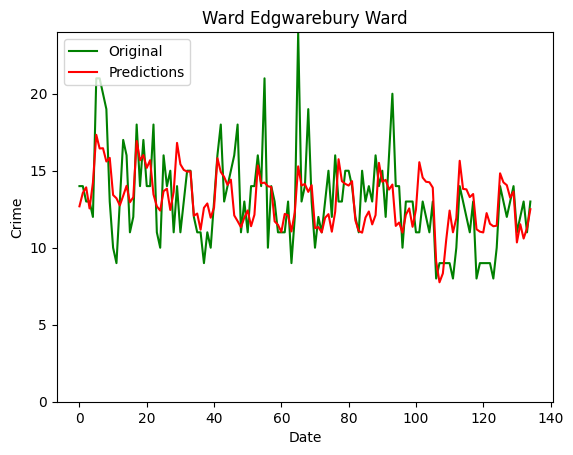

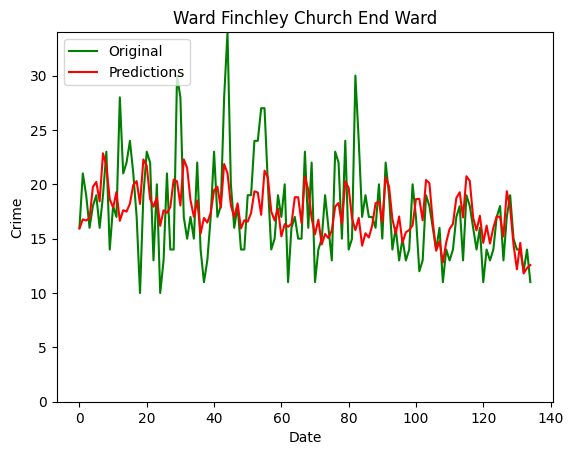

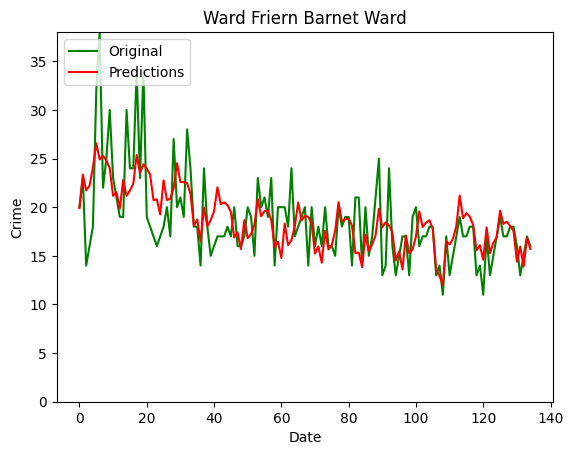

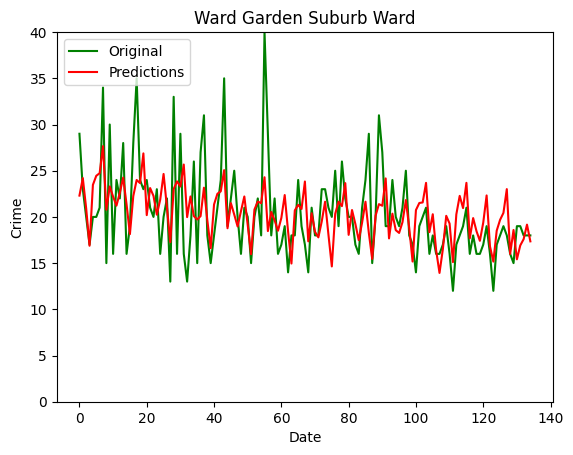

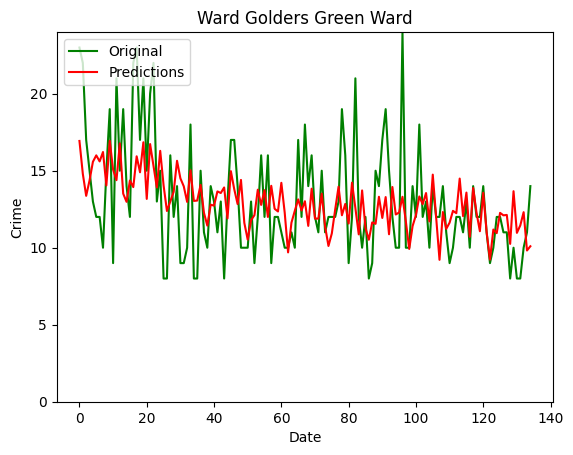

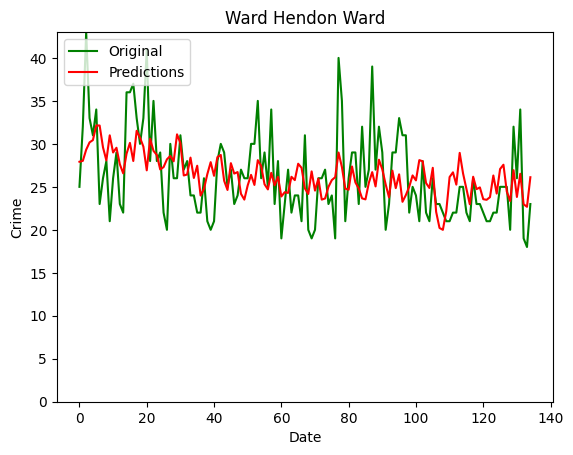

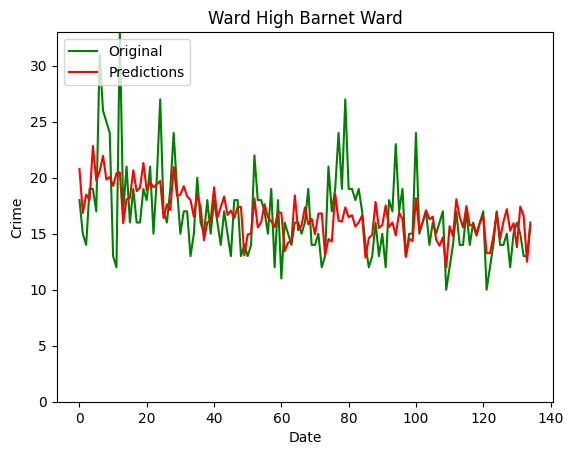

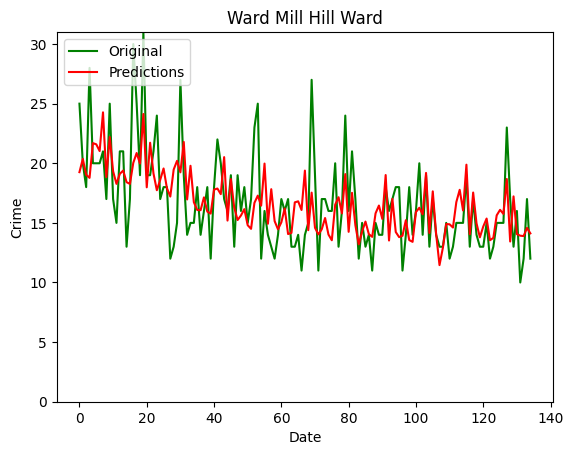

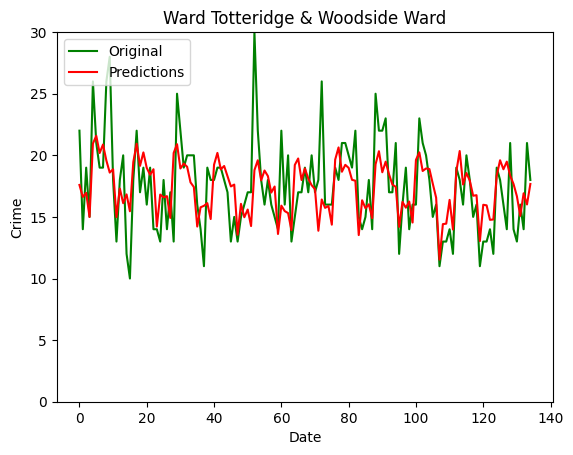

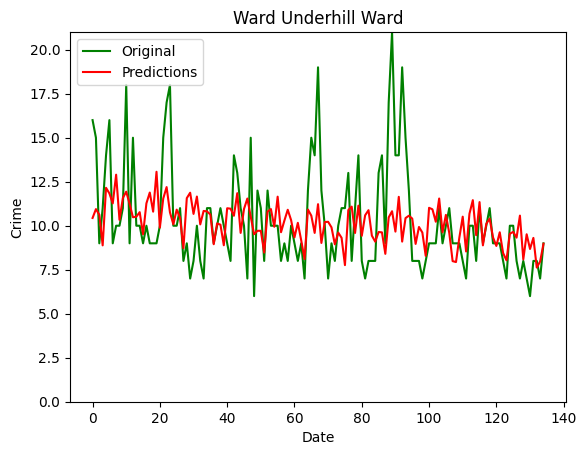

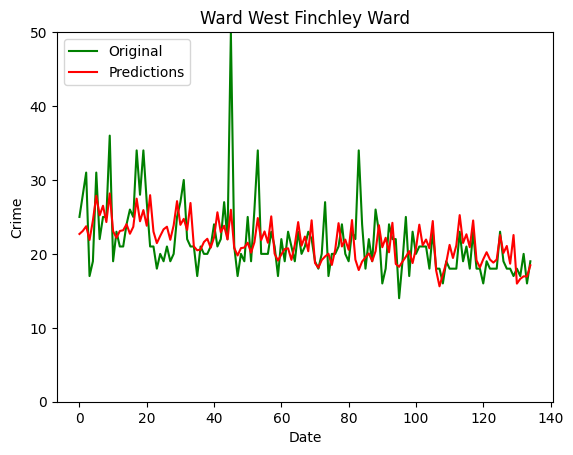

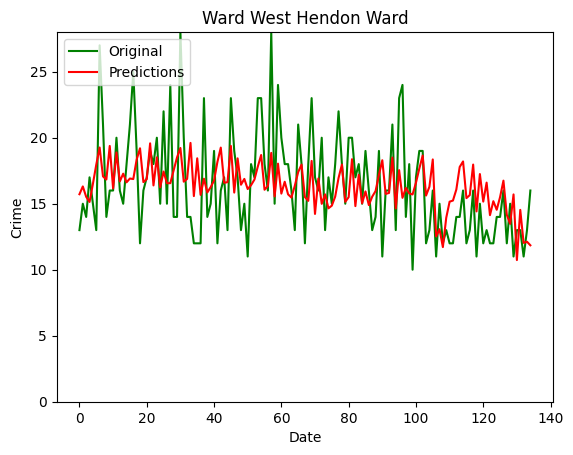

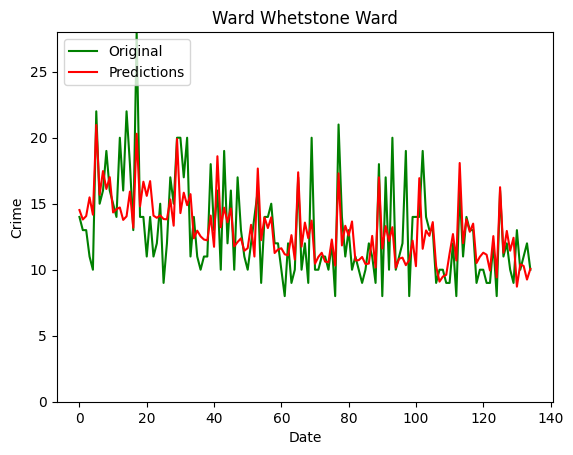

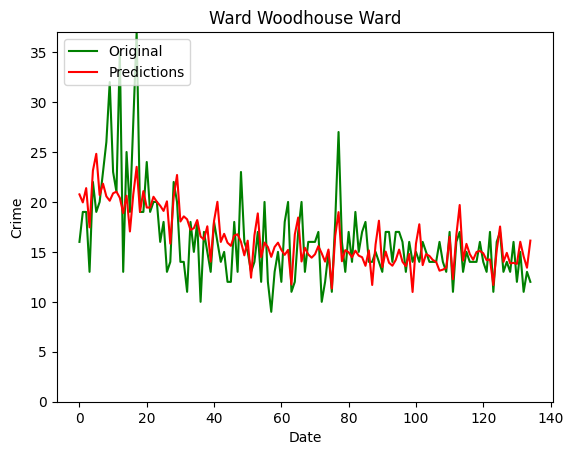

In [87]:
from sklearn.metrics import r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

scores_holt = []

# Reintroducing the seasonality to the predictions
for group, data in crime.groupby("Ward"):
    decomp = seasonal_decompose(data['y'], model='additive', period=12)
    merg = pd.merge(data, decomp.trend, on='ds')
    merg = pd.merge(merged, merg, on='ds')
    merg.set_index('ds')
    merg.dropna(inplace=True)

    # Linear regression on y
    X = merg[['Unemployment', 'UnemploymentChange', 'Inflation', 'InflationChange', 'GDP', 'GDPChange']]
    y = merg['trend']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    merg['predictions'] = predictions

    # Holt-Winters' seasonal decomposition
    model = ExponentialSmoothing(data['y'], trend=None, seasonal='add', seasonal_periods=12).fit()
    seasonality = model.season
    seasonality.name = 'seasonal'
    # merg['seasonal'] = seasonality
    merg = pd.merge(merg, seasonality, on='ds')

    # Add trend and seasonality to obtain the final predictions
    merg['predictions'] += merg['seasonal']

        # Calculate R2 score between original and predictions
    r2 = r2_score(merg['y'], merg['predictions'])
    scores_holt.append(r2)

    # Plot the crime data and predictions
    fig, ax = plt.subplots()
    ax.plot(merg['y'], color='green', label='Original')
    ax.plot(merg['predictions'], color='red', label='Predictions')



    ax.set_xlabel('Date')
    ax.set_ylabel('Crime')
    ax.legend(loc='upper left')
    plt.title('Ward ' + str(group))
    ax.set_ylim([0, merg['y'].max()])
    fig.savefig('plots/with_seasonal_holt/' + str(group) + '.png')
    # plt.show()


In [86]:
print(np.array(scores_basic).mean())
print(np.array(scores_holt).mean())

0.29365502994704396
0.2892742601327768
